In [1]:
# ----------------------------------------------------------
## Import Libraries
# ----------------------------------------------------------

import os
import sys
import matplotlib.pyplot as plt
from pathlib import Path
import configparser
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import norm
from scipy.integrate import solve_ivp

# -----------------------------
## File Paths
# -----------------------------

# Current Directory
current_dir = Path.cwd()
# Top Directory (for .py it is same as current_dir, for .ipynb it is one level up)
    # Sometimes use .parent ( for ipynb and .py in oracle cloud), someimes use nothing (.py on windows)
top_dir = current_dir.parent if current_dir.name == '7-OtherAnalyses' else current_dir


# Libs Directory
libs_dir = str(top_dir / "0-Libs")
# Config
config_dir = top_dir / "0-Config"


# Data Directory
data_dir = top_dir / "0-Data"   
    # HighRes (0)
highres_dir = str(data_dir / "0-HighRes")
    # Routine (1)
routine_dir = str(data_dir / "1-Routine")
    # Active (2)
active_dir = str(data_dir / "2-Active")
    # LongActive (3)
long_active_dir = str(data_dir / "3-LongActive")
    # LongRoutine (4)
long_routine_dir = str(data_dir / "4-LongRoutine")

# Results Directory
results_dir = (top_dir / "7-OtherAnalyses" / "Results")

# -----------------------------
## Import Libraries - Custom
# -----------------------------
sys.path.append(libs_dir)

from plant_config import get_reactor_initial_values
from asm3_model import ode_system_wrapper
from asm3_model_sunode import ode_system_sunode
from Trace_Plot_functions import plot_data
from Trace_Plot_functions import sim_all_states
from Trace_Plot_functions import plot_all_inference_lines

print("Libraries Imported")

# Config File
config = configparser.ConfigParser()
config.read(config_dir / "config.ini")
   # Seed for random number generator
seed = int(config['OVERALL']['seed'])        # Random seed
np.random.seed(seed)                         # Set random seed
data_to_use_for_run = str(config['OVERALL']['data_to_use_for_run'])  # Data to use for run
    # Reactor volumes
r1_V = float(config['REACTOR']['r1_V'])        # Volume of reactor 1
    # Parameter Ranges
range_param_k_H = tuple(map(float, config['PARAMRANGES']['range_param_k_H'].split(',')))              # Range of k_H
range_param_K_X = tuple(map(float, config['PARAMRANGES']['range_param_K_X'].split(',')))              # Range of K_X
range_param_k_STO = tuple(map(float, config['PARAMRANGES']['range_param_small_k_STO'].split(',')))          # Range of k_STO
range_param_eta_NOX = tuple(map(float, config['PARAMRANGES']['range_param_eta_NOX'].split(',')))      # Range of eta_NOX
range_param_K_O2 = tuple(map(float, config['PARAMRANGES']['range_param_K_O2'].split(',')))            # Range of K_O2
range_param_K_NOX = tuple(map(float, config['PARAMRANGES']['range_param_K_NOX'].split(',')))          # Range of K_NOX
range_param_K_S = tuple(map(float, config['PARAMRANGES']['range_param_K_S'].split(',')))              # Range of K_S
range_param_K_STO = tuple(map(float, config['PARAMRANGES']['range_param_big_K_STO'].split(',')))          # Range of K_STO
range_param_mu_H = tuple(map(float, config['PARAMRANGES']['range_param_mu_H'].split(',')))            # Range of mu_H
range_param_K_NH4 = tuple(map(float, config['PARAMRANGES']['range_param_K_NH4'].split(',')))          # Range of K_NH4
range_param_K_ALK = tuple(map(float, config['PARAMRANGES']['range_param_K_ALK'].split(',')))          # Range of K_ALK
range_param_b_H_O2 = tuple(map(float, config['PARAMRANGES']['range_param_b_H_O2'].split(',')))        # Range of b_H_O2
range_param_b_H_NOX = tuple(map(float, config['PARAMRANGES']['range_param_b_H_NOX'].split(',')))      # Range of b_H_NOX
range_param_b_STO_O2 = tuple(map(float, config['PARAMRANGES']['range_param_b_STO_O2'].split(',')))    # Range of b_STO_O2
range_param_b_STO_NOX = tuple(map(float, config['PARAMRANGES']['range_param_b_STO_NOX'].split(',')))  # Range of b_STO_NOX
range_param_mu_A = tuple(map(float, config['PARAMRANGES']['range_param_mu_A'].split(',')))            # Range of mu_A
range_param_K_A_NH4 = tuple(map(float, config['PARAMRANGES']['range_param_K_A_NH4'].split(',')))      # Range of K_A_NH4
range_param_K_A_O2 = tuple(map(float, config['PARAMRANGES']['range_param_K_A_O2'].split(',')))        # Range of K_A_O2
range_param_K_A_ALK = tuple(map(float, config['PARAMRANGES']['range_param_K_A_ALK'].split(',')))      # Range of K_A_ALK
range_param_b_A_O2 = tuple(map(float, config['PARAMRANGES']['range_param_b_A_O2'].split(',')))        # Range of b_A_O2
range_param_b_A_NOX = tuple(map(float, config['PARAMRANGES']['range_param_b_A_NOX'].split(',')))      # Range of b_A_NOX
range_param_f_S_I = tuple(map(float, config['PARAMRANGES']['range_param_f_S_I'].split(',')))          # Range of f_S_I
range_param_Y_STO_O2 = tuple(map(float, config['PARAMRANGES']['range_param_Y_STO_O2'].split(',')))    # Range of Y_STO_O2
range_param_Y_STO_NOX = tuple(map(float, config['PARAMRANGES']['range_param_Y_STO_NOX'].split(',')))  # Range of Y_STO_NOX
range_param_Y_H_O2 = tuple(map(float, config['PARAMRANGES']['range_param_Y_H_O2'].split(',')))        # Range of Y_H_O2
range_param_Y_H_NOX = tuple(map(float, config['PARAMRANGES']['range_param_Y_H_NOX'].split(',')))      # Range of Y_H_NOX
range_param_Y_A = tuple(map(float, config['PARAMRANGES']['range_param_Y_A'].split(',')))              # Range of Y_A
range_param_f_X_I = tuple(map(float, config['PARAMRANGES']['range_param_f_X_I'].split(',')))          # Range of f_X_I
range_param_i_N_S_I = tuple(map(float, config['PARAMRANGES']['range_param_i_N_S_I'].split(',')))      # Range of i_N_S_I
range_param_i_N_S_S = tuple(map(float, config['PARAMRANGES']['range_param_i_N_S_S'].split(',')))      # Range of i_N_S_S
range_param_i_N_X_I = tuple(map(float, config['PARAMRANGES']['range_param_i_N_X_I'].split(',')))      # Range of i_N_X_I
range_param_i_N_X_S = tuple(map(float, config['PARAMRANGES']['range_param_i_N_X_S'].split(',')))      # Range of i_N_X_S
range_param_i_N_BM = tuple(map(float, config['PARAMRANGES']['range_param_i_N_BM'].split(',')))        # Range of i_N_BM
range_param_i_SS_X_I = tuple(map(float, config['PARAMRANGES']['range_param_i_SS_X_I'].split(',')))    # Range of i_SS_X_I
range_param_i_SS_X_S = tuple(map(float, config['PARAMRANGES']['range_param_i_SS_X_S'].split(',')))    # Range of i_SS_X_S
range_param_i_SS_BM = tuple(map(float, config['PARAMRANGES']['range_param_i_SS_BM'].split(',')))      # Range of i_SS_BM

# Dictionary with minimum and maximum values for each parameter
theta_ranges = {
    'k_H': range_param_k_H,
    'K_X': range_param_K_X,
    'k_STO': range_param_k_STO,
    'eta_NOX': range_param_eta_NOX,
    'K_O2': range_param_K_O2,
    'K_NOX': range_param_K_NOX,
    'K_S': range_param_K_S,
    'K_STO': range_param_K_STO,
    'mu_H': range_param_mu_H,
    'K_NH4': range_param_K_NH4,
    'K_ALK': range_param_K_ALK,
    'b_H_O2': range_param_b_H_O2,
    'b_H_NOX': range_param_b_H_NOX,
    'b_STO_O2': range_param_b_STO_O2,
    'b_STO_NOX': range_param_b_STO_NOX,
    'mu_A': range_param_mu_A,
    'K_A_NH4': range_param_K_A_NH4,
    'K_A_O2': range_param_K_A_O2,
    'K_A_ALK': range_param_K_A_ALK,
    'b_A_O2': range_param_b_A_O2,
    'b_A_NOX': range_param_b_A_NOX,
    'f_S_I': range_param_f_S_I,
    'Y_STO_O2': range_param_Y_STO_O2,
    'Y_STO_NOX': range_param_Y_STO_NOX,
    'Y_H_O2': range_param_Y_H_O2,
    'Y_H_NOX': range_param_Y_H_NOX,
    'Y_A': range_param_Y_A,
    'f_X_I': range_param_f_X_I,
    'i_N_S_I': range_param_i_N_S_I,
    'i_N_S_S': range_param_i_N_S_S,
    'i_N_X_I': range_param_i_N_X_I,
    'i_N_X_S': range_param_i_N_X_S,
    'i_N_BM': range_param_i_N_BM,
    'i_SS_X_I': range_param_i_SS_X_I,
    'i_SS_X_S': range_param_i_SS_X_S,
    'i_SS_BM': range_param_i_SS_BM,
}

    # True theta params
true_param_k_H = float(config['TRUEPARAMS']['true_param_k_H'])              # True k_H
true_param_K_X = float(config['TRUEPARAMS']['true_param_K_X'])              # True K_X
true_param_k_STO = float(config['TRUEPARAMS']['true_param_small_k_STO'])          # True k_STO
true_param_eta_NOX = float(config['TRUEPARAMS']['true_param_eta_NOX'])      # True eta_NOX
true_param_K_O2 = float(config['TRUEPARAMS']['true_param_K_O2'])            # True K_O2
true_param_K_NOX = float(config['TRUEPARAMS']['true_param_K_NOX'])          # True K_NOX
true_param_K_S = float(config['TRUEPARAMS']['true_param_K_S'])              # True K_S
true_param_K_STO = float(config['TRUEPARAMS']['true_param_big_K_STO'])          # True K_STO
true_param_mu_H = float(config['TRUEPARAMS']['true_param_mu_H'])            # True mu_H
true_param_K_NH4 = float(config['TRUEPARAMS']['true_param_K_NH4'])          # True K_NH4
true_param_K_ALK = float(config['TRUEPARAMS']['true_param_K_ALK'])          # True K_ALK
true_param_b_H_O2 = float(config['TRUEPARAMS']['true_param_b_H_O2'])        # True b_H_O2
true_param_b_H_NOX = float(config['TRUEPARAMS']['true_param_b_H_NOX'])      # True b_H_NOX
true_param_b_STO_O2 = float(config['TRUEPARAMS']['true_param_b_STO_O2'])    # True b_STO_O2
true_param_b_STO_NOX = float(config['TRUEPARAMS']['true_param_b_STO_NOX'])  # True b_STO_NOX
true_param_mu_A = float(config['TRUEPARAMS']['true_param_mu_A'])            # True mu_A
true_param_K_A_NH4 = float(config['TRUEPARAMS']['true_param_K_A_NH4'])      # True K_A_NH4
true_param_K_A_O2 = float(config['TRUEPARAMS']['true_param_K_A_O2'])        # True K_A_O2
true_param_K_A_ALK = float(config['TRUEPARAMS']['true_param_K_A_ALK'])      # True K_A_ALK
true_param_b_A_O2 = float(config['TRUEPARAMS']['true_param_b_A_O2'])        # True b_A_O2
true_param_b_A_NOX = float(config['TRUEPARAMS']['true_param_b_A_NOX'])      # True b_A_NOX
true_param_f_S_I = float(config['TRUEPARAMS']['true_param_f_S_I'])          # True f_S_I
true_param_Y_STO_O2 = float(config['TRUEPARAMS']['true_param_Y_STO_O2'])    # True Y_STO_O2
true_param_Y_STO_NOX = float(config['TRUEPARAMS']['true_param_Y_STO_NOX'])  # True Y_STO_NOX
true_param_Y_H_O2 = float(config['TRUEPARAMS']['true_param_Y_H_O2'])        # True Y_H_O2
true_param_Y_H_NOX = float(config['TRUEPARAMS']['true_param_Y_H_NOX'])      # True Y_H_NOX
true_param_Y_A = float(config['TRUEPARAMS']['true_param_Y_A'])              # True Y_A
true_param_f_X_I = float(config['TRUEPARAMS']['true_param_f_X_I'])          # True f_X_I
true_param_i_N_S_I = float(config['TRUEPARAMS']['true_param_i_N_S_I'])      # True i_N_S_I
true_param_i_N_S_S = float(config['TRUEPARAMS']['true_param_i_N_S_S'])      # True i_N_S_S
true_param_i_N_X_I = float(config['TRUEPARAMS']['true_param_i_N_X_I'])      # True i_N_X_I
true_param_i_N_X_S = float(config['TRUEPARAMS']['true_param_i_N_X_S'])      # True i_N_X_S
true_param_i_N_BM = float(config['TRUEPARAMS']['true_param_i_N_BM'])        # True i_N_BM
true_param_i_SS_X_I = float(config['TRUEPARAMS']['true_param_i_SS_X_I'])    # True i_SS_X_I
true_param_i_SS_X_S = float(config['TRUEPARAMS']['true_param_i_SS_X_S'])    # True i_SS_X_S
true_param_i_SS_BM = float(config['TRUEPARAMS']['true_param_i_SS_BM'])      # True i_SS_BM

true_theta = {
    'k_H': true_param_k_H,
    'K_X': true_param_K_X,
    'k_STO': true_param_k_STO,
    'eta_NOX': true_param_eta_NOX,
    'K_O2': true_param_K_O2,
    'K_NOX': true_param_K_NOX,
    'K_S': true_param_K_S,
    'K_STO': true_param_K_STO,
    'mu_H': true_param_mu_H,
    'K_NH4': true_param_K_NH4,
    'K_ALK': true_param_K_ALK,
    'b_H_O2': true_param_b_H_O2,
    'b_H_NOX': true_param_b_H_NOX,
    'b_STO_O2': true_param_b_STO_O2,
    'b_STO_NOX': true_param_b_STO_NOX,
    'mu_A': true_param_mu_A,
    'K_A_NH4': true_param_K_A_NH4,
    'K_A_O2': true_param_K_A_O2,
    'K_A_ALK': true_param_K_A_ALK,
    'b_A_O2': true_param_b_A_O2,
    'b_A_NOX': true_param_b_A_NOX,
    'f_S_I': true_param_f_S_I,
    'Y_STO_O2': true_param_Y_STO_O2,
    'Y_STO_NOX': true_param_Y_STO_NOX,
    'Y_H_O2': true_param_Y_H_O2,
    'Y_H_NOX': true_param_Y_H_NOX,
    'Y_A': true_param_Y_A,
    'f_X_I': true_param_f_X_I,
    'i_N_S_I': true_param_i_N_S_I,
    'i_N_S_S': true_param_i_N_S_S,
    'i_N_X_I': true_param_i_N_X_I,
    'i_N_X_S': true_param_i_N_X_S,
    'i_N_BM': true_param_i_N_BM,
    'i_SS_X_I': true_param_i_SS_X_I,
    'i_SS_X_S': true_param_i_SS_X_S,
    'i_SS_BM': true_param_i_SS_BM
}
# ----------------------------------------------------------
## Load Data from csv
# ----------------------------------------------------------

# Highres (0)
data_highres_influent_states = pd.read_csv(highres_dir + "/HighRes_Influent_States.csv")
data_highres_effluent_states = pd.read_csv(highres_dir + "/HighRes_Effluent_States.csv")
data_highres_influent_compounds = pd.read_csv(highres_dir + "/HighRes_Influent_Compounds.csv")
data_highres_effluent_compounds = pd.read_csv(highres_dir + "/HighRes_Effluent_Compounds.csv")
# Routine (1)
data_routine_influent_states = pd.read_csv(routine_dir + "/Routine_Influent_States.csv")
data_routine_effluent_states = pd.read_csv(routine_dir + "/Routine_Effluent_States.csv")
data_routine_influent_compounds = pd.read_csv(routine_dir + "/Routine_Influent_Compounds.csv")
data_routine_effluent_compounds = pd.read_csv(routine_dir + "/Routine_Effluent_Compounds.csv")
# Active (2)
data_active_influent_states = pd.read_csv(active_dir + "/Active_Influent_States.csv")
data_active_effluent_states = pd.read_csv(active_dir + "/Active_Effluent_States.csv")
data_active_influent_compounds = pd.read_csv(active_dir + "/Active_Influent_Compounds.csv")
data_active_effluent_compounds = pd.read_csv(active_dir + "/Active_Effluent_Compounds.csv")
# LongActive (3)
data_longactive_influent_states = pd.read_csv(long_active_dir + "/LongActive_Influent_States.csv")
data_longactive_effluent_states = pd.read_csv(long_active_dir + "/LongActive_Effluent_States.csv")
data_longactive_influent_compounds = pd.read_csv(long_active_dir + "/LongActive_Influent_Compounds.csv")
data_longactive_effluent_compounds = pd.read_csv(long_active_dir + "/LongActive_Effluent_Compounds.csv")
# LongRoutine (4)
data_longroutine_influent_states = pd.read_csv(long_routine_dir + "/LongRoutine_Influent_States.csv")
data_longroutine_effluent_states = pd.read_csv(long_routine_dir + "/LongRoutine_Effluent_States.csv")
data_longroutine_influent_compounds = pd.read_csv(long_routine_dir + "/LongRoutine_Influent_Compounds.csv")
data_longroutine_effluent_compounds = pd.read_csv(long_routine_dir + "/LongRoutine_Effluent_Compounds.csv")

# ----------------------------------------------------------
## Data to use for identifiability
# ----------------------------------------------------------

data_mapping_influent_states = {
    'HighRes': data_highres_influent_states,
    'Routine': data_routine_influent_states,
    'Active': data_active_influent_states,
    'LongActive': data_longactive_influent_states,
    'LongRoutine': data_longroutine_influent_states,
}
data_mapping_effluent_states = {
    'HighRes': data_highres_effluent_states,
    'Routine': data_routine_effluent_states,
    'Active': data_active_effluent_states,
    'LongActive': data_longactive_effluent_states,
    'LongRoutine': data_longroutine_effluent_states,
}
data_mapping_influent_compounds = {
    'HighRes': data_highres_influent_compounds,
    'Routine': data_routine_influent_compounds,
    'Active': data_active_influent_compounds,
    'LongActive': data_longactive_influent_compounds,
    'LongRoutine': data_longroutine_influent_compounds,
}
data_mapping_effluent_compounds = {
    'HighRes': data_highres_effluent_compounds,
    'Routine': data_routine_effluent_compounds,
    'Active': data_active_effluent_compounds,
    'LongActive': data_longactive_effluent_compounds,
    'LongRoutine': data_longroutine_effluent_compounds,
}

try:
    Data_Influent_states = data_mapping_influent_states[data_to_use_for_run]
    Data_Effluent_states = data_mapping_effluent_states[data_to_use_for_run]
    Data_Influent_compounds = data_mapping_influent_compounds[data_to_use_for_run]
    Data_Effluent_compounds = data_mapping_effluent_compounds[data_to_use_for_run]
except KeyError:
    raise ValueError("Invalid data for sanpling. Choose from HighRes, Routine, LongRoutine, Active, or LongActive.")


# ----------------------------------------------------------
print("Config and Data loaded")

# Arviz rcParams
plt.rcParams['figure.constrained_layout.use'] = True


Libraries Imported
Config and Data loaded


In [2]:
# ----------------------------------------------------------
## Run model with true parameters
# ----------------------------------------------------------


reactor_volumes = [
    r1_V    # m3, Reactor 1 Volume
]
# Ode system
influent_data = Data_Influent_states.to_numpy()
ode_system = lambda t,y,theta: ode_system_wrapper(t=t, y=y, theta=theta, influentData=influent_data, reactorVolumes=reactor_volumes)
t_data = influent_data[:, 0] # Time points to evaluate function at
t_eval = np.linspace(min(t_data), max(t_data), 1000) # Time points to evaluate function at
y0 = get_reactor_initial_values(top_dir)

# true_theta dict to array
true_theta_array = np.array(list(true_theta.values())).transpose()

# Simulate ODE model with true theta
sol = solve_ivp(
    fun= ode_system,
    t_span=(min(t_data), max(t_data)), # Time span for simulation
    y0=y0, # Initial conditions
    t_eval=t_eval, # Time points to evaluate function at
    method='BDF',
    args=(true_theta_array,) # Arguments to pass to the function
)

# Extract the states from the solution
sol_flow = np.interp(t_eval, t_data, influent_data[:, 1])  # Interpolated Effluent flowrate
sol_COD = sol.y[1] + sol.y[2] + sol.y[7] + sol.y[8] + sol.y[10] + sol.y[9] + sol.y[11]
sol_NH4 = sol.y[3]
sol_NOx = sol.y[5]
sol_TKN = sol.y[3] + sol.y[4]
sol_Alkalinity = sol.y[6]
sol_TSS = sol.y[12]

true_compounds_df = pd.DataFrame({
    'Time': sol.t,
    'Flowrate': sol_flow,
    'COD': sol_COD,
    'NH4+NH3': sol_NH4,
    'NO3+NO2': sol_NOx,
    'TKN': sol_TKN,
    'Alkalinity': sol_Alkalinity,
    'TSS': sol_TSS
})


C:\Users\ruanv\AppData\Local\Temp\ipykernel_51964\1762124880.py:37: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


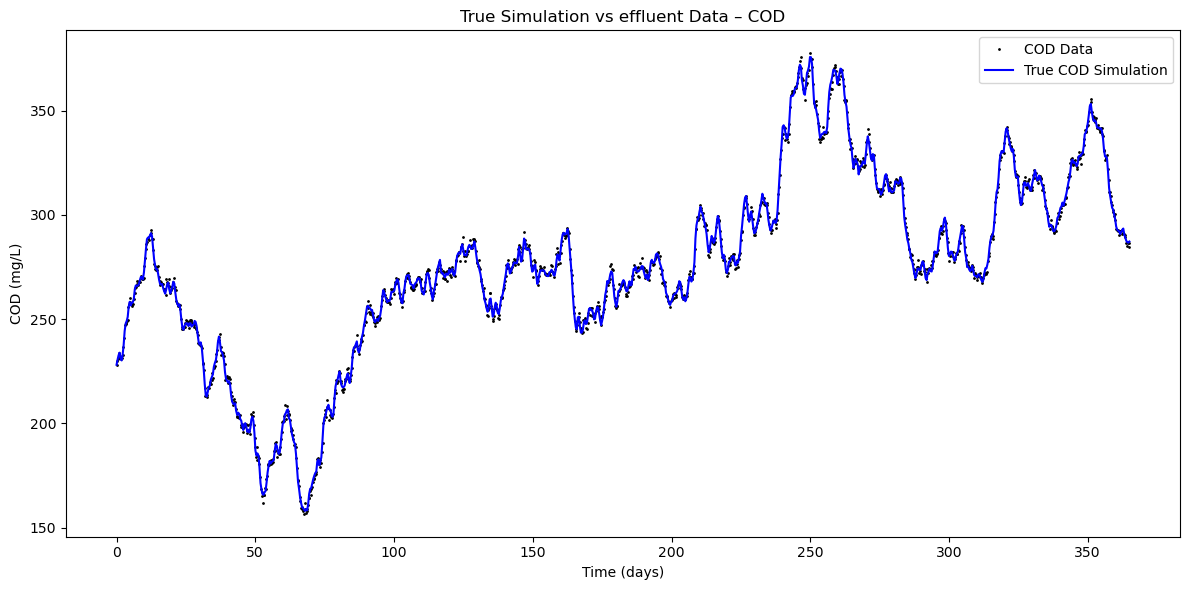

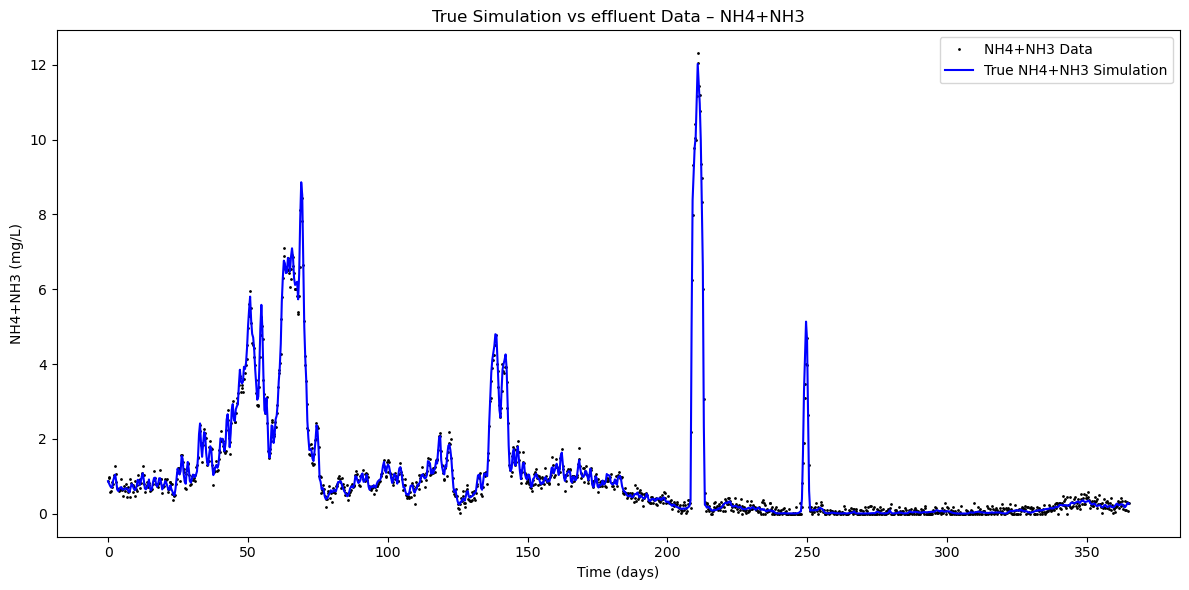

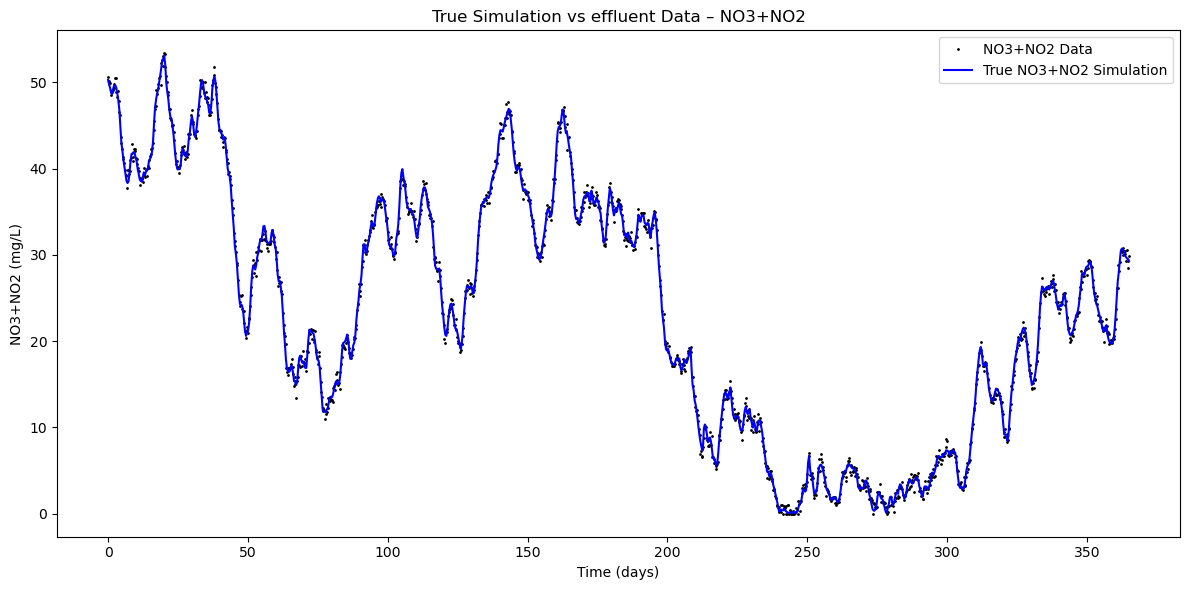

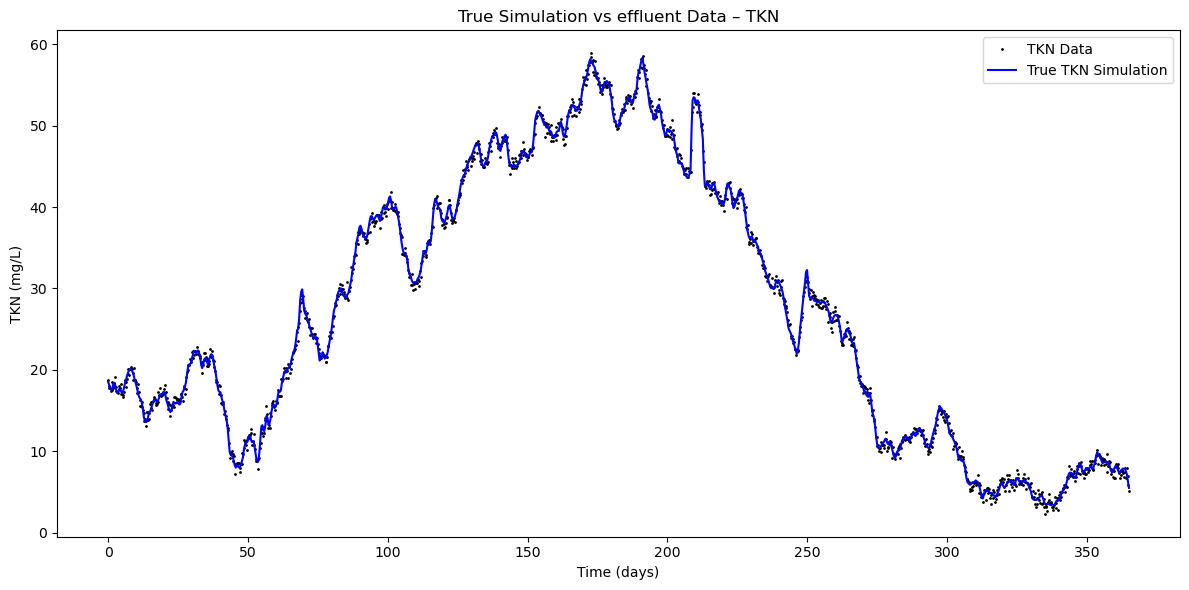

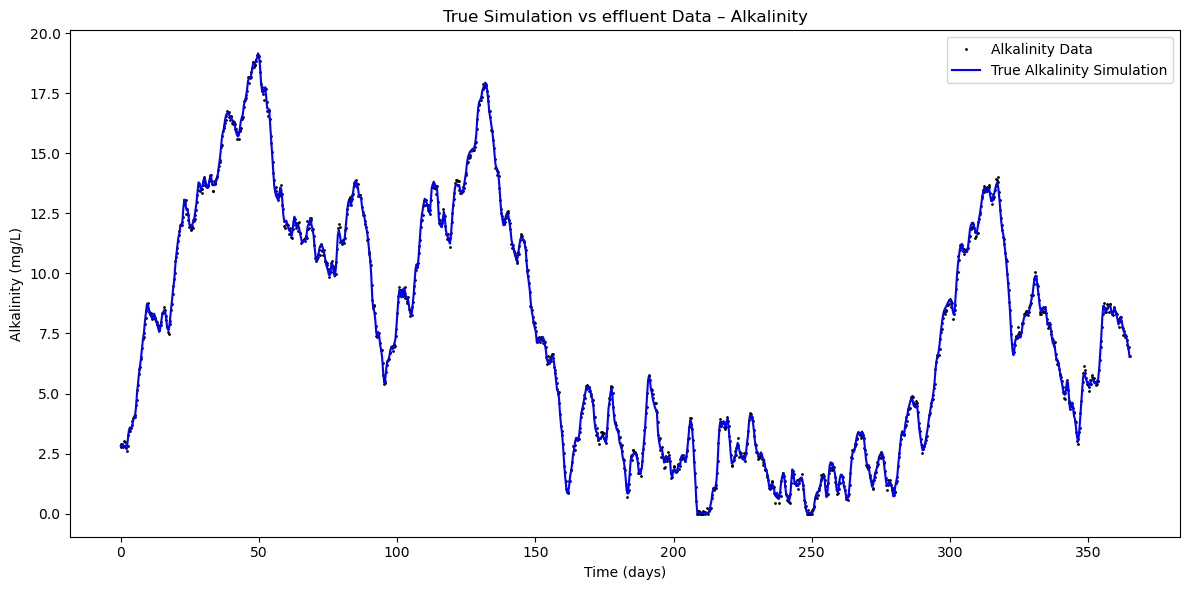

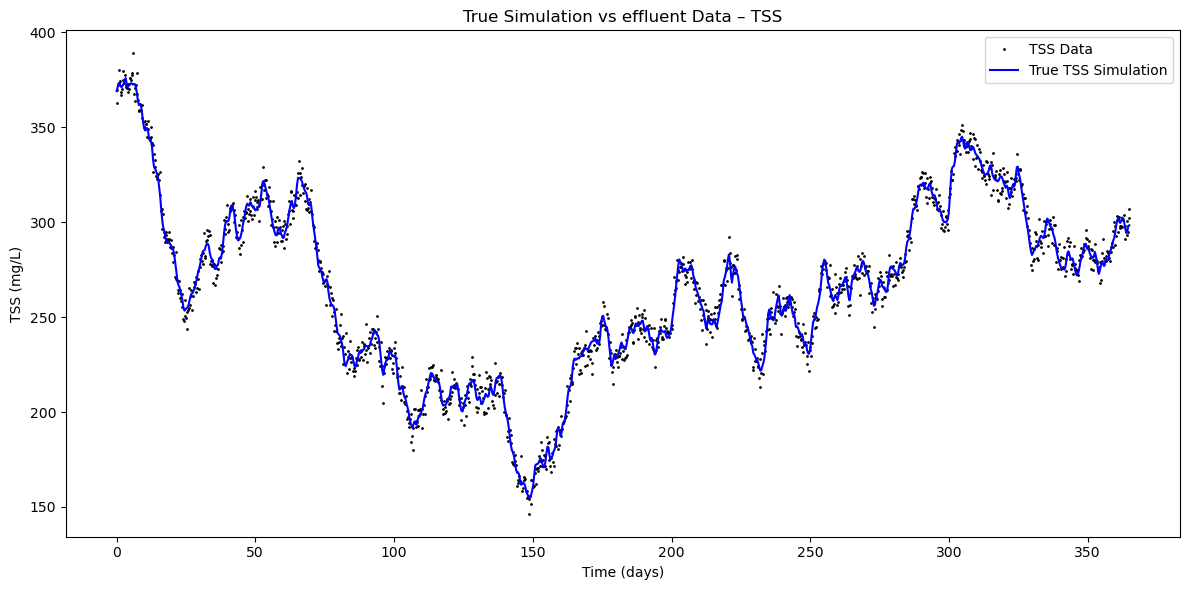

In [3]:
# ----------------------------------------------------------
## Plot true model simulation versus effluent data
# ----------------------------------------------------------

compound_keys = ['COD', 'NH4+NH3', 'NO3+NO2', 'TKN', 'Alkalinity', 'TSS']

for key in compound_keys:
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot raw data (effluent)
    ax.plot(
        Data_Effluent_compounds['Time'],
        Data_Effluent_compounds[key],
        linestyle='None',
        marker='.',
        markersize=2,
        color='black',
        label=f'{key} Data',
    )

    # Plot true model simulation
    ax.plot(
        true_compounds_df['Time'],
        true_compounds_df[key],
        linestyle='-',
        linewidth=1.5,
        color='blue',
        label=f'True {key} Simulation',
    )

    # Final touches for the plot
    ax.set_title(f'True Simulation vs effluent Data – {key}')
    ax.set_xlabel('Time (days)')
    ax.set_ylabel(f'{key} (mg/L)')
    ax.legend()
    
    plt.tight_layout()
    plt.show()



In [4]:
# ----------------------------------------------------------
## Grab Sensitivity Analysis Data
# ----------------------------------------------------------

# Load NAASI_compounds and NAASI_states csv files 
Case = "HighRes"  # Case can be HighRes, Routine, Active, LongActive, LongRoutine
naasi_compounds_path = top_dir / "8-Results" / Case / "NAASI_compounds.csv"
naasi_states_path = top_dir / "8-Results" / Case / "NAASI_states.csv"

# naasi_compounds_path = top_dir / "2-Sensitivity" / "Results" / "NAASI_compounds.csv"
# naasi_states_path = top_dir / "2-Sensitivity" / "Results" / "NAASI_states.csv"

if not naasi_compounds_path.exists() or not naasi_states_path.exists():
    raise FileNotFoundError("NAASI_compounds.csv or NAASI_states.csv not found in the expected directory.")

# Load the data into pandas DataFrames
naasi_compounds_df = pd.read_csv(naasi_compounds_path)
naasi_states_df = pd.read_csv(naasi_states_path)




In [5]:
# ----------------------------------------------------------
## Calcuate MSE and plot MSE vs parameters fixed to prior mean values
# ----------------------------------------------------------

# The following steps are done:
# 1) Create a theta_sample array,m initially with all true thetea values
# 2) For the NAASI_compounds, take the compound with lowest NAASI value and change the corresponding parameter to the prior mean value
# 3) Simulate the model with the modified theta_sample
# 4) Calculate the MSE between the simulated compounds and the true compounds simulation
# 5) Store the MSE and the parameter that was fixed to prior mean value (as well as the NAASI value of the highest added parameter)
# 6) Repeat steps 2-5 for all compounds in NAASI_compounds_df until all parameters are fixed to prior mean values
# 7) Plot the MSE vs number of parameters fixed to prior mean values 
# 8) Plot the MSE vs NAASI value (simlar to 7 just different x-axis)

# 9) Repeat for NAASI_states_df as well for separate plot

# Prior means for each parameter
prior_means_dict = {
    'k_H': np.mean(theta_ranges['k_H']),
    'K_X': np.mean(theta_ranges['K_X']),
    'k_STO': np.mean(theta_ranges['k_STO']),
    'eta_NOX': np.mean(theta_ranges['eta_NOX']),
    'K_O2': np.mean(theta_ranges['K_O2']),
    'K_NOX': np.mean(theta_ranges['K_NOX']),
    'K_S': np.mean(theta_ranges['K_S']),
    'K_STO': np.mean(theta_ranges['K_STO']),
    'mu_H': np.mean(theta_ranges['mu_H']),
    'K_NH4': np.mean(theta_ranges['K_NH4']),
    'K_ALK': np.mean(theta_ranges['K_ALK']),
    'b_H_O2': np.mean(theta_ranges['b_H_O2']),
    'b_H_NOX': np.mean(theta_ranges['b_H_NOX']),
    'b_STO_O2': np.mean(theta_ranges['b_STO_O2']),
    'b_STO_NOX': np.mean(theta_ranges['b_STO_NOX']),
    'mu_A': np.mean(theta_ranges['mu_A']),
    'K_A_NH4': np.mean(theta_ranges['K_A_NH4']),
    'K_A_O2': np.mean(theta_ranges['K_A_O2']),
    'K_A_ALK': np.mean(theta_ranges['K_A_ALK']),
    'b_A_O2': np.mean(theta_ranges['b_A_O2']),
    'b_A_NOX': np.mean(theta_ranges['b_A_NOX']),
    'f_S_I': np.mean(theta_ranges['f_S_I']),
    'Y_STO_O2': np.mean(theta_ranges['Y_STO_O2']),
    'Y_STO_NOX': np.mean(theta_ranges['Y_STO_NOX']),
    'Y_H_O2': np.mean(theta_ranges['Y_H_O2']),
    'Y_H_NOX': np.mean(theta_ranges['Y_H_NOX']),
    'Y_A': np.mean(theta_ranges['Y_A']),
    'f_X_I': np.mean(theta_ranges['f_X_I']),
    'i_N_S_I': np.mean(theta_ranges['i_N_S_I']),
    'i_N_S_S': np.mean(theta_ranges['i_N_S_S']),
    'i_N_X_I': np.mean(theta_ranges['i_N_X_I']),
    'i_N_X_S': np.mean(theta_ranges['i_N_X_S']),
    'i_N_BM': np.mean(theta_ranges['i_N_BM']),
    'i_SS_X_I': np.mean(theta_ranges['i_SS_X_I']),
    'i_SS_X_S': np.mean(theta_ranges['i_SS_X_S']),
    'i_SS_BM': np.mean(theta_ranges['i_SS_BM']),
}
prior_means = np.array(list(prior_means_dict.values())).transpose()

# 1) Create a theta_sample array, initially with all true theta values
theta_sample = np.array(list(true_theta.values())).transpose()

# 2) Loop through NAASI_compounds_df
mse_values_compounds = []
naasi_compounds_df_sorted = naasi_compounds_df.sort_values(by='AASI', ascending=True)
for index, row in naasi_compounds_df_sorted.iterrows():
    # Get the parameter with the lowest NAASI value
    param_name = row['Parameter']
    naasi_value = row['AASI']
    
    # 2) Change the corresponding parameter to the prior mean value
    param_index = list(true_theta.keys()).index(param_name)
    theta_sample[param_index] = prior_means[param_index]
    
    # 3) Simulate the model with the modified theta_sample
    sol = solve_ivp(
        fun= ode_system,
        t_span=(min(t_data), max(t_data)), # Time span for simulation
        y0=y0, # Initial conditions
        t_eval=t_eval, # Time points to evaluate function at
        method='BDF',
        args=(theta_sample,) # Arguments to pass to the function
    )

    simulated_compounds_df = pd.DataFrame({
        'Time': sol.t,
        'Flowrate': np.interp(sol.t, t_data, influent_data[:, 1]),
        'COD': sol.y[1] + sol.y[2] + sol.y[7] + sol.y[8] + sol.y[10] + sol.y[9] + sol.y[11],
        'NH4+NH3': sol.y[3],
        'NO3+NO2': sol.y[5],
        'TKN': sol.y[3] + sol.y[4],
        'Alkalinity': sol.y[6],
        'TSS': sol.y[12]
    })
    
    # 4) Calculate the MSE between the simulated compounds and the true compounds simulation
    mse = np.mean((simulated_compounds_df.drop(columns=['Time', 'Flowrate']) - true_compounds_df.drop(columns=['Time', 'Flowrate']))**2)
    params_fixed = index + 1  # Number of parameters fixed to prior mean values
    
    # 5) Store the MSE and the parameter that was fixed to prior mean value (as well as the NAASI value of the highest added parameter)
    mse_values_compounds.append((mse, param_name, naasi_value, params_fixed))

C:\Users\ruanv\AppData\Local\Temp\ipykernel_51964\367934640.py:30: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


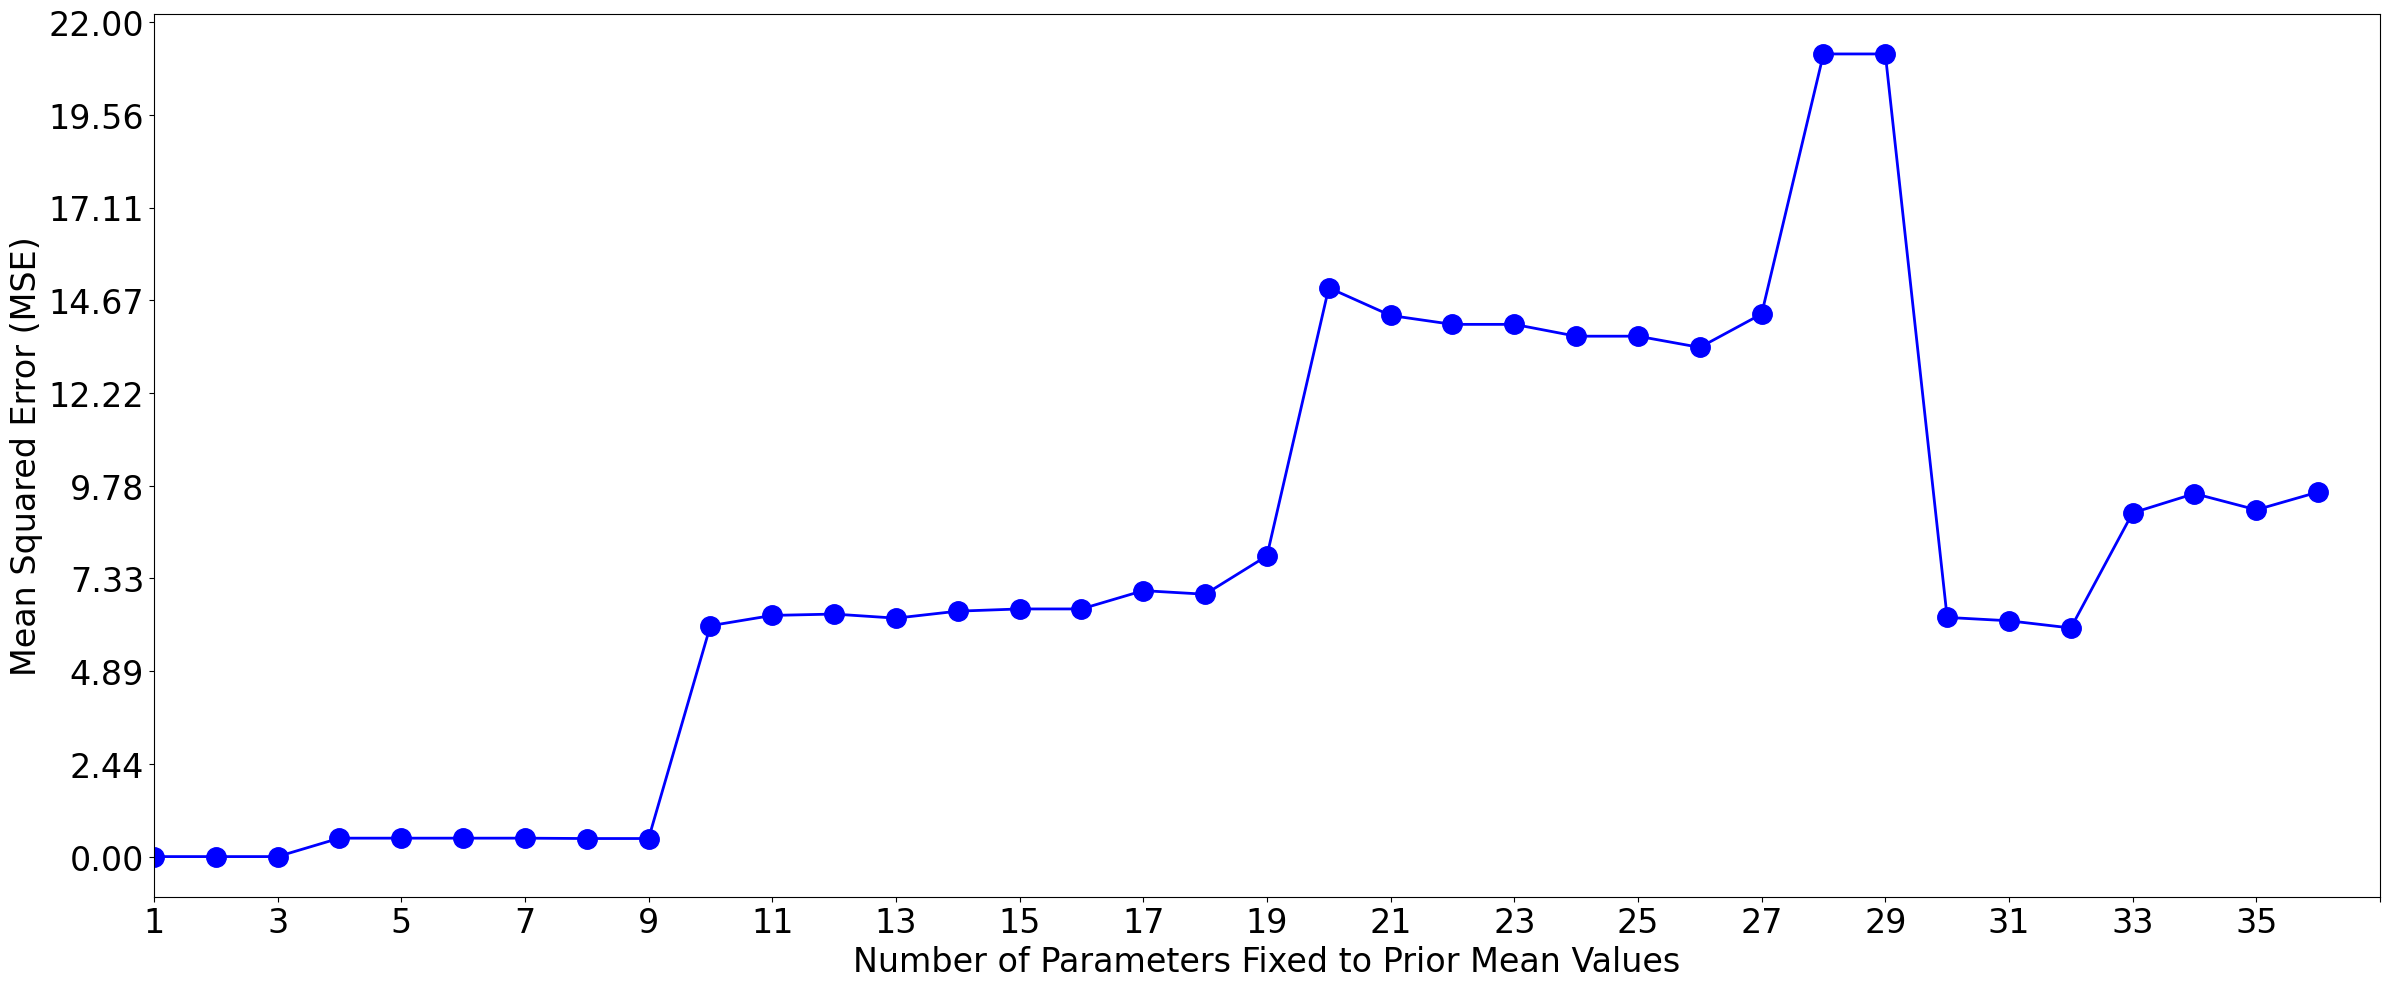

C:\Users\ruanv\AppData\Local\Temp\ipykernel_51964\367934640.py:64: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


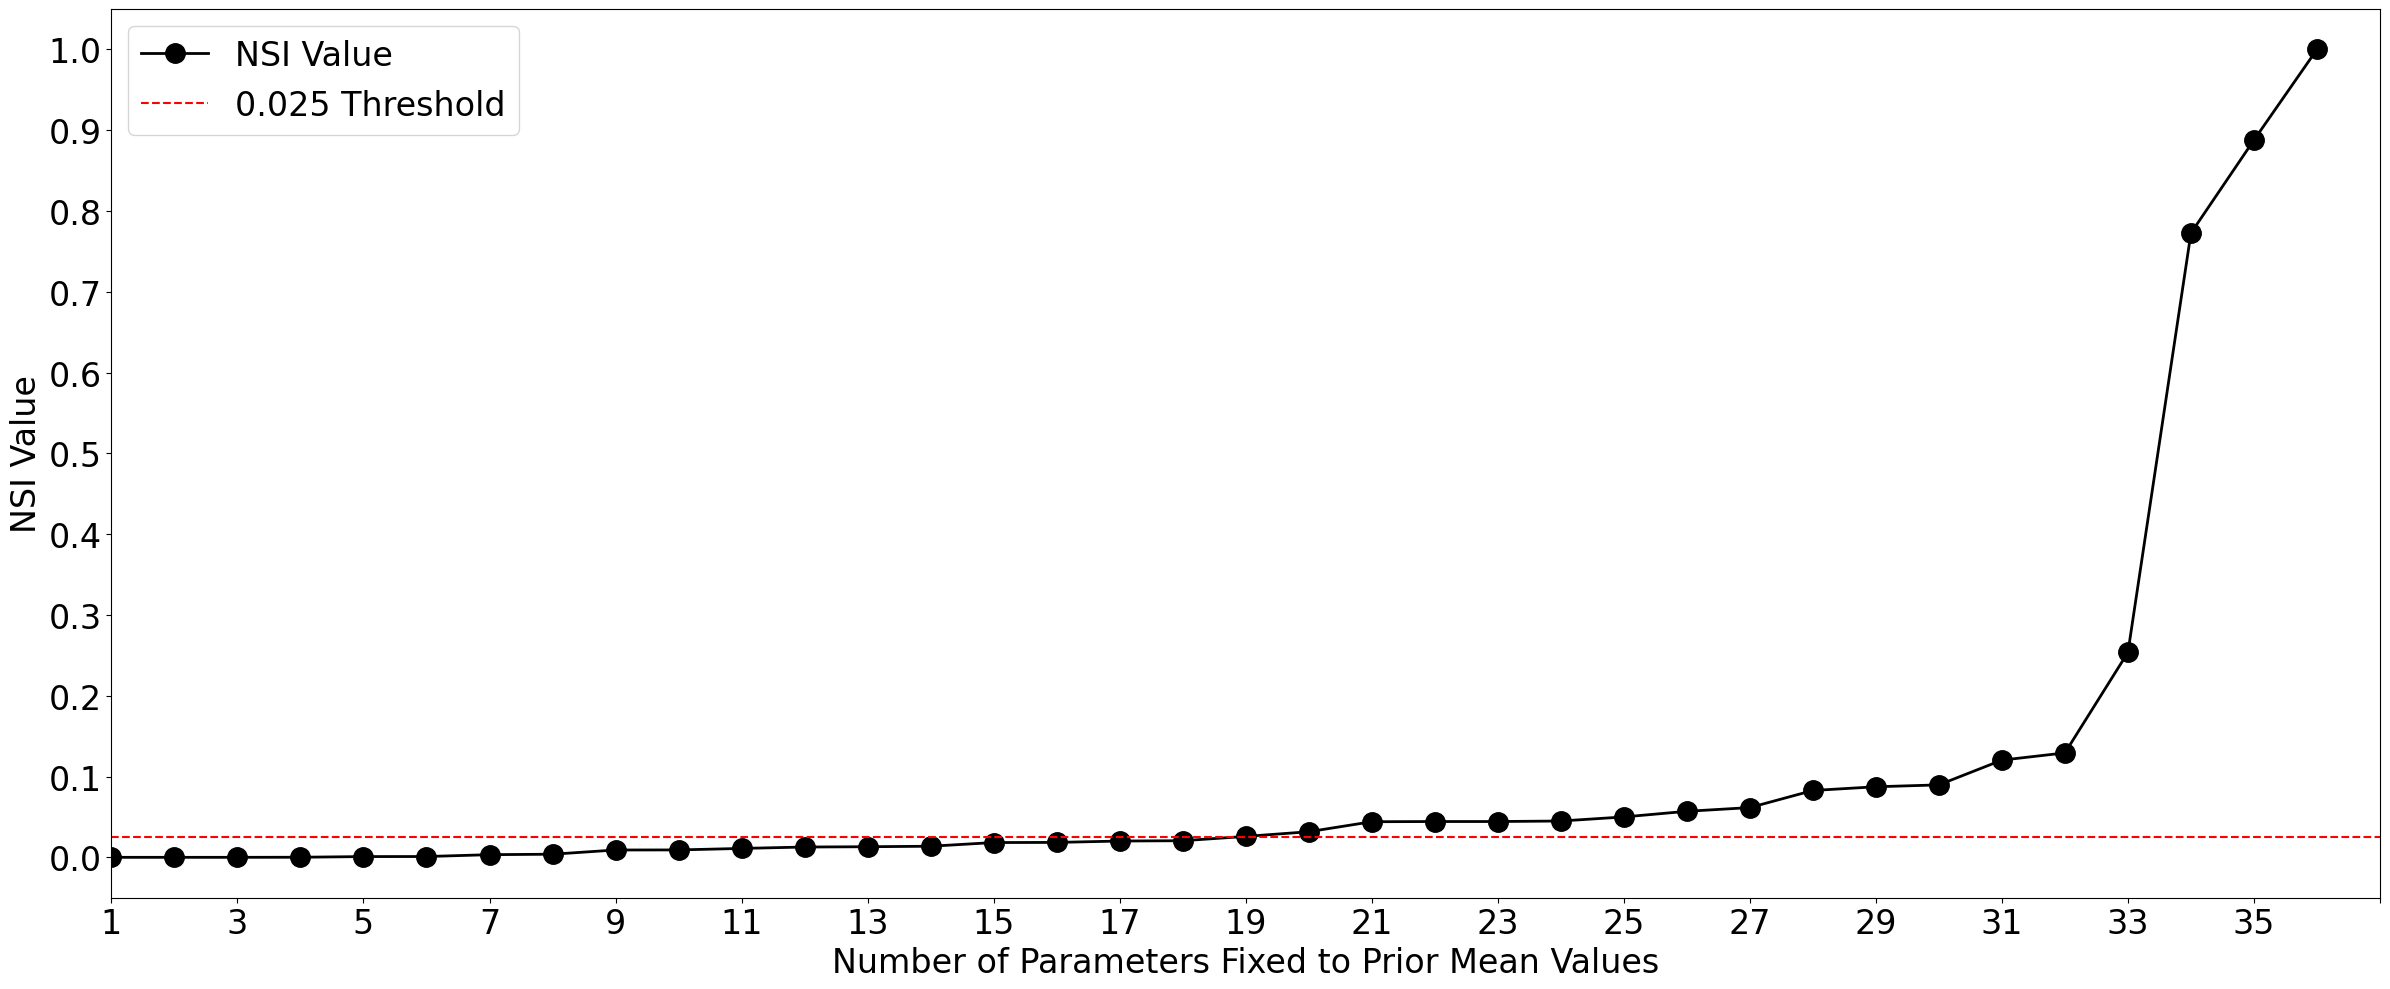

C:\Users\ruanv\AppData\Local\Temp\ipykernel_51964\367934640.py:78: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


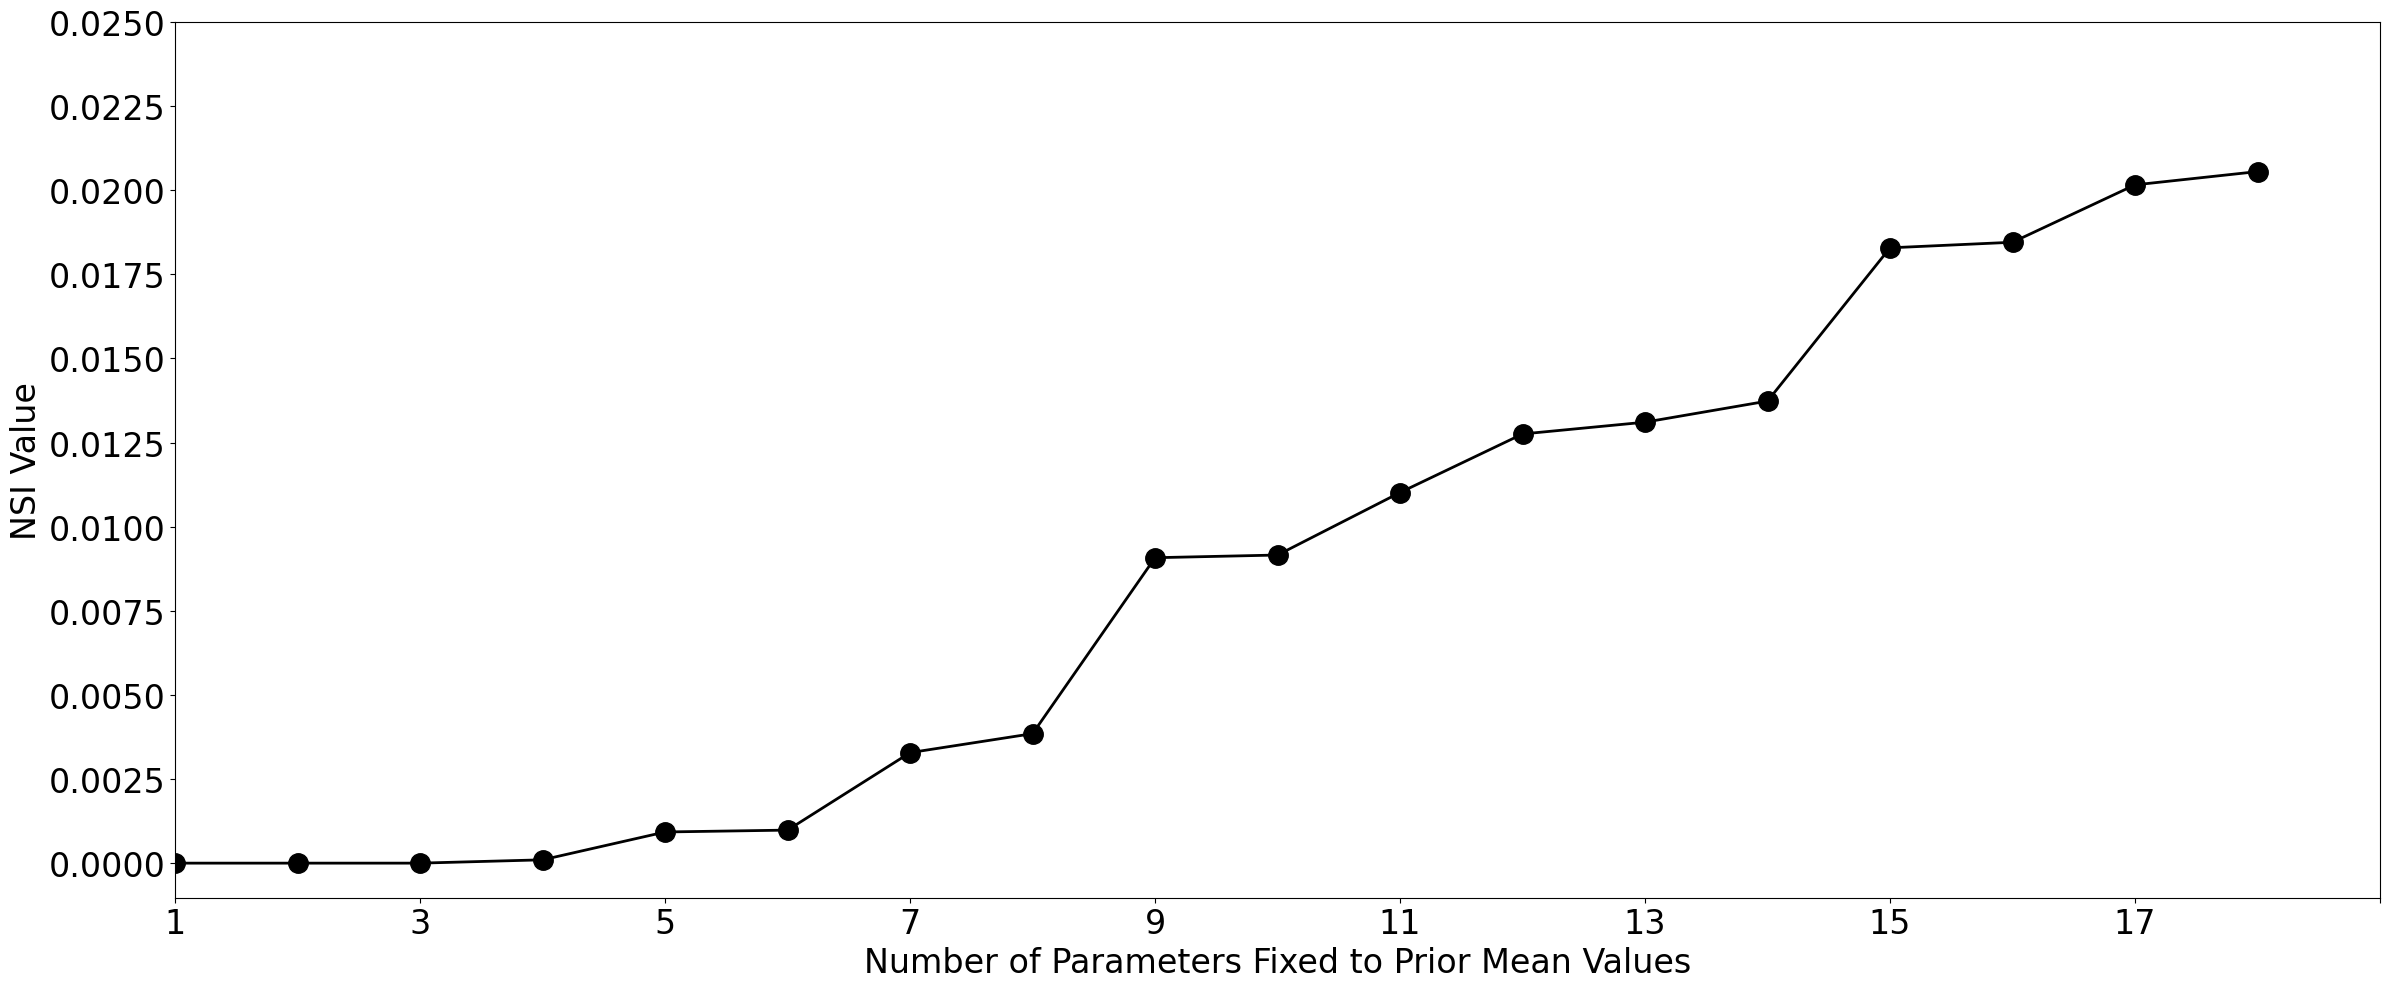

In [6]:

# Plot MSE vs number of parameters fixed to prior mean values
mse_values_compounds = np.array(mse_values_compounds)

params_fixed_compounds = mse_values_compounds[:, 3]
mse_compounds = mse_values_compounds[:, 0]

# Ensure mse_compounds is float
mse_compounds = mse_compounds.astype(float)

# Define y-axis ticks: from 0 to a clean rounded max
max_mse = float(np.nanmax(mse_compounds))
rounded_max_mse = np.ceil(max_mse)
num_ticks = 10
yticks = np.linspace(0, rounded_max_mse, num=num_ticks)


fontsize = 24

# Plot MSE vs number of parameters fixed to prior mean values
plt.figure(figsize=(24, 10))
plt.plot(params_fixed_compounds, mse_compounds, marker='o', linestyle='-', color='blue', markersize=14, linewidth=2)
# plt.title('MSE vs Number of Parameters Fixed to Prior Mean Values (Compounds)', fontsize=fontsize)
plt.xlabel('Number of Parameters Fixed to Prior Mean Values', fontsize=fontsize)
plt.ylabel('Mean Squared Error (MSE)', fontsize=fontsize)
plt.yticks(yticks, fontsize=fontsize)
plt.xticks(np.arange(0, len(params_fixed_compounds)+1, 2), fontsize=fontsize)
plt.xlim(0, len(params_fixed_compounds))
plt.grid(False)
# plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


# # Plot MSE vs NAASI value
naasi_values_compounds = mse_values_compounds[:, 2].astype(float)
naasi_values_compounds_below_025 = naasi_values_compounds[naasi_values_compounds < 0.025]
params_fixed_compounds_below_025 = params_fixed_compounds[naasi_values_compounds < 0.025]

# plt.figure(figsize=(14, 8))
# plt.plot(naasi_values_compounds, mse_compounds, marker='o', linestyle='-', color='green')
# plt.title('MSE vs NAASI Value (Compounds)')
# plt.xlabel('NAASI Value', fontsize=fontsize)
# plt.ylabel('Mean Squared Error (MSE)', fontsize=fontsize)
# plt.yticks(yticks, fontsize=fontsize)
# plt.xticks(np.arange(0, 1.01, 0.05), fontsize=fontsize)
# plt.grid(False)
# # plt.grid(True, which='both', linestyle='--', alpha=0.5)
# plt.tight_layout()
# plt.show()


# Plot NAASI vs number of parameters fixed to prior mean values
plt.figure(figsize=(24, 10))
plt.plot(params_fixed_compounds, naasi_values_compounds, marker='o', linestyle='-', color='black', markersize=14, linewidth=2, label='NSI Value')
plt.hlines(y=0.025, xmin=0, xmax=len(naasi_values_compounds), colors='red', linestyles='--', label='0.025 Threshold')
# plt.title('NAASI vs Number of Parameters Fixed to Prior Mean Values (Compounds)', fontsize=fontsize)
plt.legend(fontsize=fontsize)
plt.xlabel('Number of Parameters Fixed to Prior Mean Values', fontsize=fontsize)
plt.ylabel('NSI Value', fontsize=fontsize)
plt.xticks(np.arange(0, len(params_fixed_compounds)+1, 2), fontsize=fontsize)
plt.xlim(0, len(params_fixed_compounds))
plt.yticks(np.arange(0, 1.01, 0.1), fontsize=fontsize)
plt.grid(False)
plt.tight_layout()
plt.show()

# Same as above, but focus on below 0.025 NAASI value only

plt.figure(figsize=(24, 10))
plt.plot(params_fixed_compounds_below_025, naasi_values_compounds_below_025, marker='o', linestyle='-', color='black', markersize=14, linewidth=2)
# plt.title('NAASI vs Number of Parameters Fixed to Prior Mean Values (Compounds) (Below 0.025)', fontsize=fontsize)
plt.xlabel('Number of Parameters Fixed to Prior Mean Values', fontsize=fontsize)
plt.ylabel('NSI Value', fontsize=fontsize)
plt.xticks(np.arange(0, len(params_fixed_compounds_below_025)+1, 2), fontsize=fontsize)
plt.xlim(0, len(params_fixed_compounds_below_025))
plt.yticks(np.arange(0, 0.026, 0.0025), fontsize=fontsize)
plt.grid(False)
plt.tight_layout()
plt.show()

C:\Users\ruanv\AppData\Local\Temp\ipykernel_51964\1417834950.py:51: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


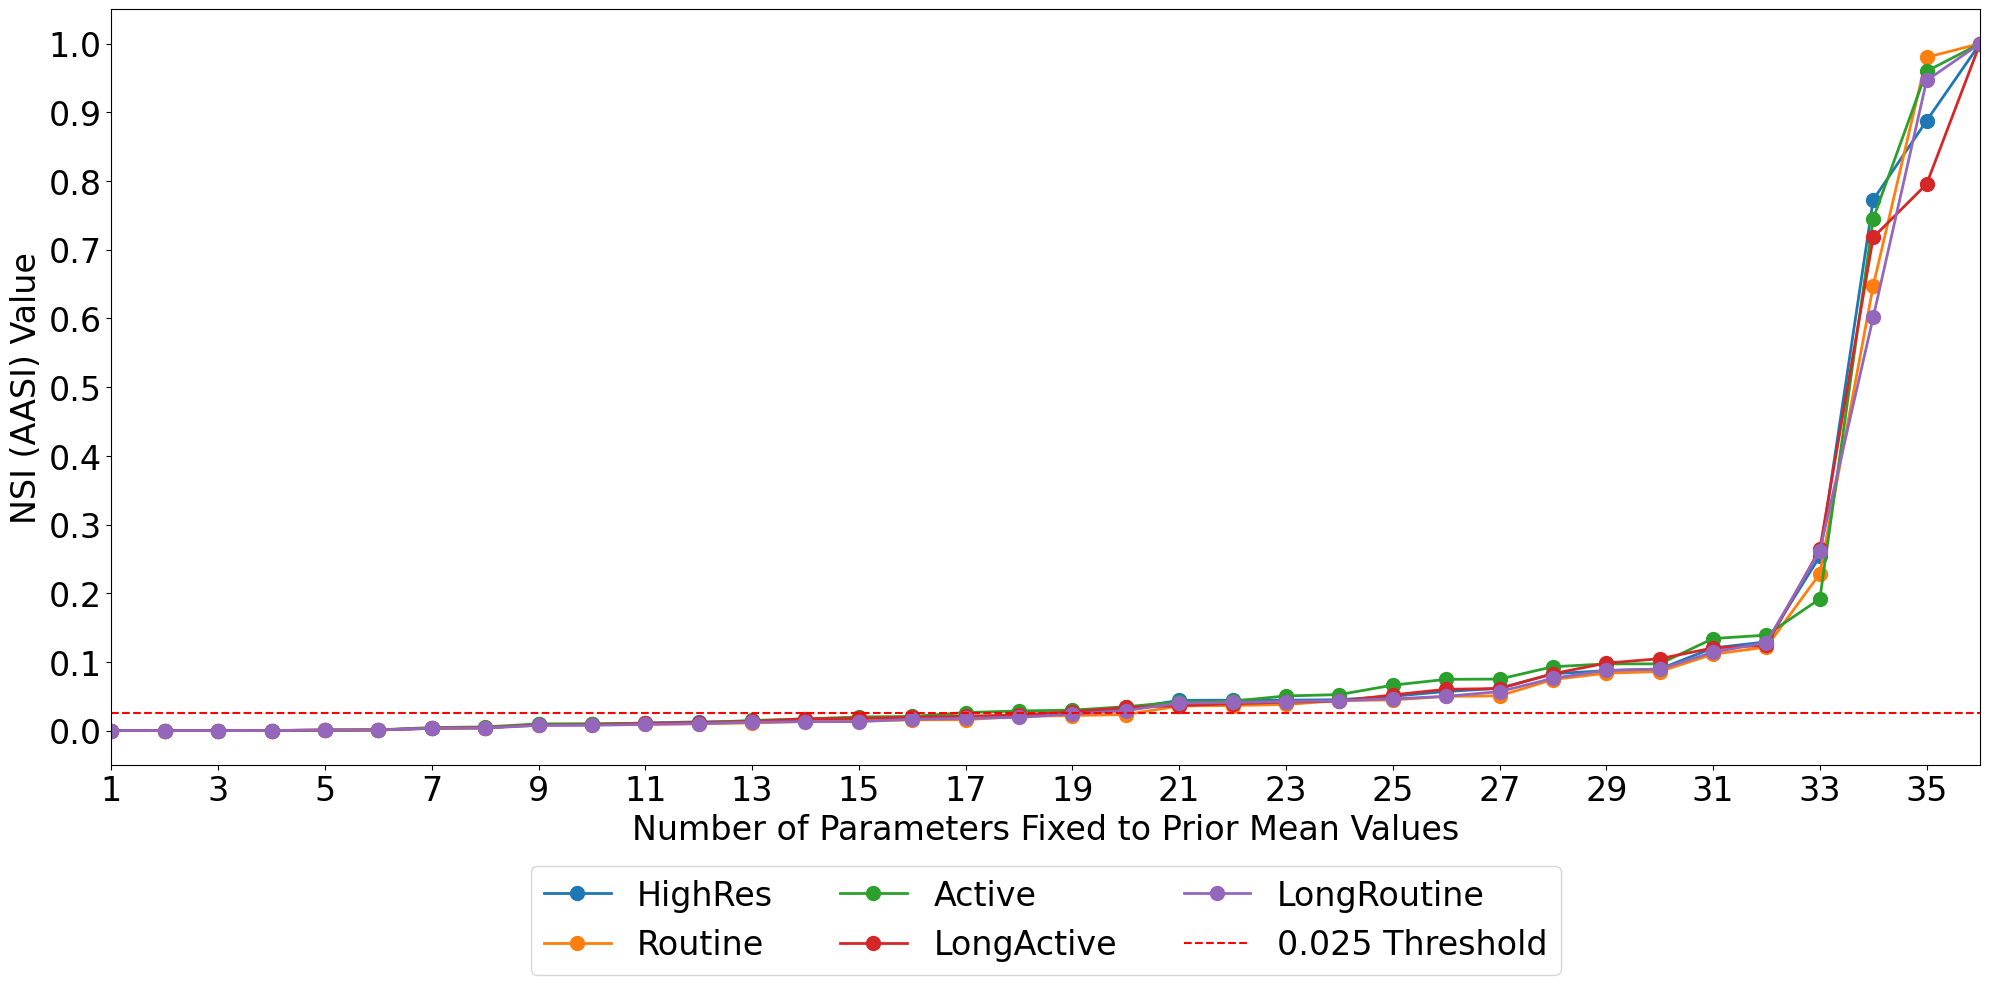

In [7]:
# ----------------------------------------------------------
# NSI (AASI) vs Number of Fixed Parameters — COMPOUNDS (All Cases)
# ----------------------------------------------------------


# Choose which cases to include (must match your 8-Results/<Case>/ structure)
cases_to_plot = ["HighRes", "Routine", "Active", "LongActive", "LongRoutine"]

# Where NAASI files live per case
def naasi_compounds_path_for(case: str) -> Path:
    return top_dir / "8-Results" / case / "NAASI_compounds.csv"

# Collect sorted NSI sequences for each case
series_by_case = {}
max_len = 0

for case in cases_to_plot:
    f = naasi_compounds_path_for(case)
    if not f.exists():
        print(f"[skip] NAASI_compounds.csv not found for case '{case}' at: {f}")
        continue
    df = pd.read_csv(f)
    if "AASI" not in df.columns or "Parameter" not in df.columns:
        print(f"[skip] Missing required columns in {f.name} for case '{case}'")
        continue
    df_sorted = df.sort_values(by="AASI", ascending=True).reset_index(drop=True)
    y_vals = df_sorted["AASI"].astype(float).to_numpy()
    x_vals = np.arange(1, len(y_vals) + 1)
    series_by_case[case] = (x_vals, y_vals)
    max_len = max(max_len, len(y_vals))

if not series_by_case:
    raise RuntimeError("No valid NAASI_compounds.csv files found for the requested cases.")

# Plot
fontsize = 24
plt.figure(figsize=(20, 10))
for case, (x, y) in series_by_case.items():
    plt.plot(x, y, marker='o', linestyle='-', linewidth=2, markersize=10, label=case)

# Threshold line at 0.025
plt.hlines(y=0.025, xmin=1, xmax=max_len, colors='red', linestyles='--', label='0.025 Threshold')

plt.xlabel('Number of Parameters Fixed to Prior Mean Values', fontsize=fontsize)
plt.ylabel('NSI (AASI) Value', fontsize=fontsize)
plt.xlim(1, max_len)
plt.xticks(np.arange(1, max_len + 1, 2), fontsize=fontsize)
plt.yticks(np.arange(0, 1.01, 0.1), fontsize=fontsize)
plt.legend(fontsize=fontsize, ncol=3, loc='lower center', bbox_to_anchor=(0.5, -0.30))
plt.grid(False)
plt.tight_layout()
plt.show()



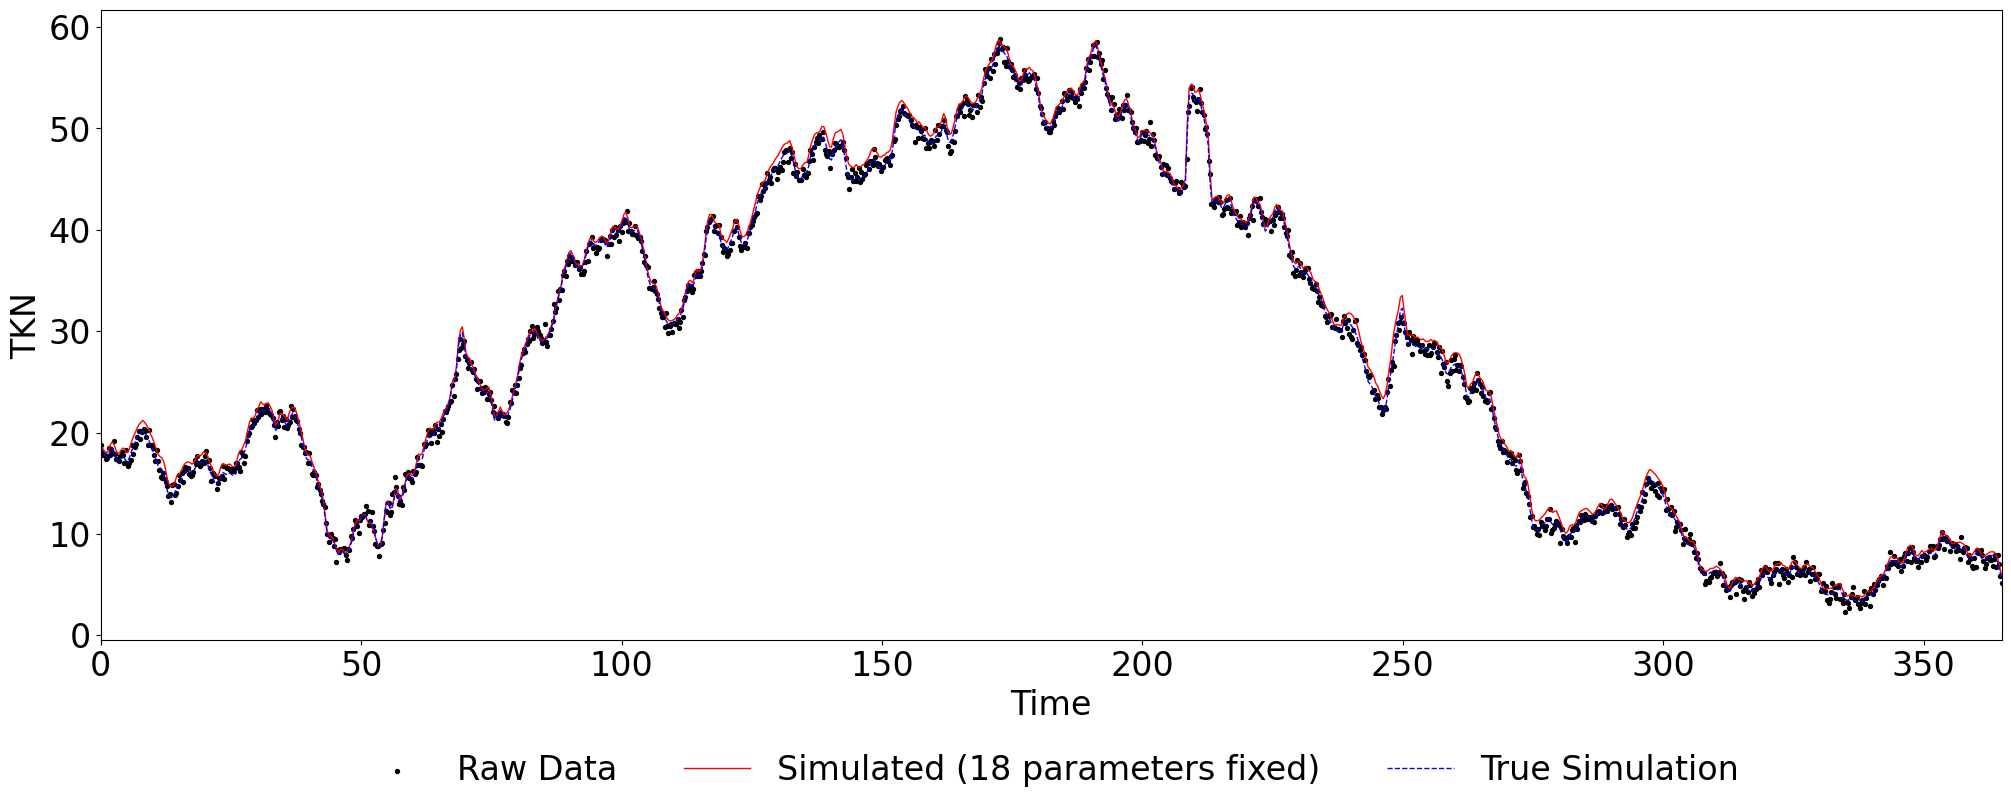

In [12]:

# Plot configuration
compound_name = 'TKN' # COD, NH4+NH3, NO3+NO2, TKN, Alkalinity, TSS
num_parameters_fixed = 18
plot_fontsize = 24

time_points = simulated_compounds_df['Time'].values  # time axis

# Raw data and true simulation
raw_data = Data_Effluent_compounds[['Time', compound_name]].dropna()
true_sim = true_compounds_df[compound_name].values

# Adjust parameters and run a single simulation
theta_sample = np.array(list(true_theta.values())).copy()
sorted_params = naasi_compounds_df.sort_values(by='AASI', ascending=True).reset_index(drop=True)
params_to_fix = sorted_params.head(num_parameters_fixed)

for _, row in params_to_fix.iterrows():
    param_name = row['Parameter']
    param_index = list(true_theta.keys()).index(param_name)
    theta_sample[param_index] = prior_means[param_index]

sol = solve_ivp(
    fun=ode_system,
    t_span=(min(t_data), max(t_data)),
    y0=y0,
    t_eval=t_eval,
    method='BDF',
    args=(theta_sample,)
)

sim_df = pd.DataFrame({
    'Time': sol.t,
    'COD': sol.y[1] + sol.y[2] + sol.y[7] + sol.y[8] + sol.y[10] + sol.y[9] + sol.y[11],
    'NH4+NH3': sol.y[3],
    'NO3+NO2': sol.y[5],
    'TKN': sol.y[3] + sol.y[4],
    'Alkalinity': sol.y[6],
    'TSS': sol.y[12]
})

selected_sim = sim_df[compound_name].values
selected_label = f"{len(params_to_fix)} parameters fixed"

# Y-axis limits focused on the data
combined_values = np.concatenate([
    raw_data[compound_name].values,
    true_sim[~np.isnan(true_sim)],
    selected_sim[~np.isnan(selected_sim)]
])
y_min, y_max = combined_values.min(), combined_values.max()
padding = 0.05 * (y_max - y_min) if y_max > y_min else 0.5 * max(abs(y_max), 1.0)

# Set up plot
fig, ax = plt.subplots(figsize=(20, 8))
ax.scatter(raw_data['Time'], raw_data[compound_name], color='black', s=8, label='Raw Data', alpha=1)
ax.plot(time_points, selected_sim, lw=1, color='red', linestyle='-', ms=0, label=f'Simulated ({selected_label})')
ax.plot(time_points, true_sim, lw=1, color='blue', linestyle='--', label='True Simulation')

# ax.set_title(f'{compound_name} | {selected_label}', fontsize=plot_fontsize)
ax.set_xlim(min(time_points), max(time_points))
ax.set_ylim(y_min - padding, y_max + padding)
ax.set_xlabel('Time', fontsize=plot_fontsize)
ax.set_ylabel(compound_name, fontsize=plot_fontsize)
ax.tick_params(axis='both', labelsize=plot_fontsize)
# ax.legend(loc='upper right', fontsize=plot_fontsize)
# change legend at bottom with 3 columns
ax.legend(loc='lower center', bbox_to_anchor=(0.5, -0.28), fontsize=plot_fontsize, ncol=3, frameon=False)
ax.grid(False)

plt.show()
